# Try to make the RNN work... with 100 timepoints only...

In [21]:
# Import Libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import torch

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

def euler_method(func, y0, t, params):
    num_eqns = len(y0)
    y = np.zeros((len(t), num_eqns))
    y[0] = y0
    dt = t[1] - t[0]
    for i in range(1, len(t)):
        y[i] = y[i - 1] + dt * func(t[i - 1], y[i - 1], params)
    return y

# Example function representing a system of ODEs with parameters
def system_of_odes(t, y, params):
    dydt = np.zeros_like(y)

    m1, p1, m2, p2, m3, p3 = y
    k1, k2 = params #only 3 ks are parameters to infer
    k3 = 246.96291990024542
    a1 = a2 = a3 = 24.78485282457379
    g1 = g2 = g3 = 0.024884149937163258
    n1 = n2 = n3 = 5
    b1 = b2 = b3 = 33.82307682700831
    dm1 = dm2 = dm3 = 1.143402097500176
    dp1 = dp2 = dp3 = 0.7833664565550977

    dydt[0] = -dm1 * m1 + (a1 / (1 + ((1/k1) * p2) ** n1)) + g1
    dydt[1] = (b1 * m1) - (dp1 * p1)
    dydt[2] = -dm2 * m2 + (a2 / (1 + ((1/k2) * p3) ** n2)) + g2
    dydt[3] = (b2 * m2) - (dp2 * p2)
    dydt[4] = -dm3 * m3 + (a3 / (1 + ((1/k3) * p1) ** n3)) + g3
    dydt[5] = (b3 * m3)-(dp3 * p3)
    
    return dydt

# Initial conditions
true_params = [
    246.96291990024542, 246.96291990024542]
num_timesteps = 100
num_trajectories = 6
y0 = np.array([0, 1, 0, 3, 0, 2])
t = np.linspace(0, 100, num_timesteps)

def simulator(parameter_set):
    full_tensor = torch.zeros((num_trajectories * num_timesteps)).unsqueeze(0)
    if len(parameter_set) == 1:
        for params in parameter_set:
            y = euler_method(system_of_odes, y0, t, params)
            y_transposed = y.T
            concatenated_trajectories = y_transposed.flatten()
            yt = torch.tensor(concatenated_trajectories)
            final_tensor = yt.unsqueeze(0).unsqueeze(-1)
            return final_tensor
    else:
        for params in parameter_set:
            y = euler_method(system_of_odes, y0, t, params)
            y_transposed = y.T
            concatenated_trajectories = y_transposed.flatten()
            yt = torch.tensor(concatenated_trajectories)
            true_tensor = yt.unsqueeze(0)
            full_tensor = torch.cat((full_tensor, true_tensor), dim=0)
        n_sims = full_tensor.size(0)
        output_tensor = full_tensor[1:n_sims]
        out = output_tensor.unsqueeze(-1)
        return out
    
num_dim = 2
prior = utils.BoxUniform(low=10**-2 * torch.ones(num_dim), high=250 * torch.ones(num_dim))

In [22]:
true_data = simulator(torch.tensor(true_params).unsqueeze(0))
true_data.shape

torch.Size([1, 600, 1])

In [23]:
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

In [20]:
# The embedding net is a RNN consisting of a single layer of 100 GRU units (Cho et al, 2014)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size #Number of GRU units
        self.input_size = input_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)   #Batch size is specified by the second shape number of input. 
                                                                        #In this case, batch_size = 1000 because input.shape is [1, 6000]. (https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)
                                                                        #Weights are therefore updated after a pass through the entire trajectory
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x): #The input will be (batch_size, seq_length, inp_size)
        x = x.view(-1, 100, 6) # have a sequence length of 100 and 6 input size
        h = torch.zeros(self.num_layers, x.size(0), self.hidden_size)  # Number of layers, batch_size and number of GRU units
        gru_out, _ = self.gru(x, h)                # GRU layer, we don't store the hn (hidden state output)
        output = self.linear(gru_out[:, -1, :])     #Last hidden state
        return output

# Define RNN
num_layers = 1
input_size = 6
# batch_size = 100
output_size = 25 #We want 1-dimensional embeddings of length = 25 (1x25)
hidden_size = 100 #GRU units

embedding_net_RNN = RNN(input_size, hidden_size, output_size, num_layers)

In [6]:
# It should be 3, 1, 6000
batch_size = 2
fourdim = simulator_wrapper(prior.sample((batch_size,)))
fourdim.shape

torch.Size([2, 6000, 1])

In [14]:
fourdim_r = fourdim.view(-1, 1000, 6)
fourdim_r.shape #every timepoint is a list of 6...

torch.Size([2, 1000, 6])

In [15]:
gru = nn.GRU(6, 100, batch_first=True)
fc = nn.Linear(100, 25)
h = torch.zeros(1, fourdim_r.size(0), 100)  # Number of layers, batch_size and number of GRU units
gru_out, _ = gru(fourdim_r, h)                # GRU layer, we don't store the hn (hidden state output)
gru_out.shape

torch.Size([2, 1000, 100])

In [16]:
output = fc(gru_out[:, -1, :])
output.shape

torch.Size([2, 25])

# now SNPE

In [25]:
#Parallelise it
# PART 1: Edited code from original sbi repos. Functions edited: simulate_for_sbi, and all the functions it contains.
#Main changes: defined simulator_seeded globally rather than within simulate_in_batches function, and re-imported torch within simulator_seeded 
#NO changes need to be made in this file

# PART 2: Essentially the unparallelised code with 2 extra arguments in the simulate_for_sbi line

##################################### PART 1 #########################################
import joblib
import contextlib
import random
import torch
import numpy as np

from torch import Tensor, split, randint, cat
from typing import Any, Callable, Optional, Tuple, Union
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm.auto import tqdm

import sbi
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os

from sbi.inference import SNLE, prepare_for_sbi
# No longer importing simulate_for_sbi from the package, we use the one defined above
from sbi import utils as utils
from sbi import analysis as analysis

def seed_all_backends(seed: Optional[Union[int, Tensor]] = None) -> None:
    if seed is None:
        seed = int(torch.randint(1_000_000, size=(1,)))
    else:
        # Cast Tensor to int (required by math.random since Python 3.11)
        seed = int(seed)

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # type: ignore
    torch.backends.cudnn.benchmark = False # type: ignore

def simulator_seeded(simulator: Callable, theta: Tensor, seed: int) -> Tensor:
    import torch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    with torch.random.fork_rng(devices=[]):
        torch.manual_seed(seed)
        return simulator(theta)

def simulate_in_batches(simulator: Callable, theta: Tensor, sim_batch_size: int = 1, num_workers: int = 1,
                        seed: Optional[int] = None, show_progress_bars: bool = True, ) -> Tensor:

    num_sims, *_ = theta.shape
    seed_all_backends(seed)

    if num_sims == 0:
        x = torch.tensor([])
    elif sim_batch_size is not None and sim_batch_size < num_sims:
        batches = split(theta, sim_batch_size, dim=0)

        if num_workers != 1:
            batch_seeds = randint(high=1_000_000, size=(len(batches),))

            with tqdm_joblib(
                tqdm(batches, disable=not show_progress_bars,
                     desc=f"Running {num_sims} simulations in {len(batches)} batches.", total=len(batches),)) as _:
                simulation_outputs = Parallel(n_jobs=num_workers)(delayed(simulator_seeded)(simulator, batch, batch_seed)
                    for batch, batch_seed in zip(batches, batch_seeds))
        else:
            pbar = tqdm(total=num_sims, disable=not show_progress_bars, desc=f"Running {num_sims} simulations.", )

            with pbar:
                simulation_outputs = []
                for batch in batches:
                    simulation_outputs.append(simulator_seeded(simulator, batch, seed))
                    pbar.update(sim_batch_size)

        x = cat(simulation_outputs, dim=0)
    else:
        x = simulator(theta)

    return x


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()

def simulate_for_sbi(simulator: Callable, proposal: Any, num_simulations: int, num_workers: int = 1,
                     simulation_batch_size: int = 1, seed: Optional[int] = None,
                     show_progress_bar: bool = True, ) -> Tuple[Tensor, Tensor]:

    theta = proposal.sample((num_simulations,))

    x = simulate_in_batches(simulator=simulator, theta=theta, sim_batch_size=simulation_batch_size,
                            num_workers=num_workers, seed=seed, show_progress_bars=show_progress_bar,)

    return theta, x

######################################################################################################

simulation_batch_size = 200
num_simulations = 1200

# To parallelise, set number of CPUs to be used. Note: parallelise anything that has num_rounds>2 and/or num_simulations>50
# to see total available CPUs: print(os.cpu_count())

CPUs_to_use = 8

total_CPUs = os.cpu_count()
num_workers = CPUs_to_use - total_CPUs -1
# num_workers = -1 uses all cpus
# num_workers = -2 uses all cpus but one etc https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html
if CPUs_to_use > total_CPUs:
    raise ValueError(f"Cannot use more CPUs than are available. Available CPUs: {total_CPUs}")

In [26]:
num_rounds = 2
#Reset embedding net?

simulator_wrapper, prior = prepare_for_sbi(simulator, prior)


# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net_RNN, hidden_features=25, num_transforms=2)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)

posteriors = []
proposal = prior

num_simulations = 1000
simulation_batch_size = 150

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_wrapper, proposal, num_simulations=num_simulations, simulation_batch_size=simulation_batch_size, num_workers=num_workers)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(true_data)

posterior_samples = posterior.sample((50000,), x=true_data)
_ = analysis.pairplot(
    posterior_samples, limits=[[-100, 300], [-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)

Running 1000 simulations in 7 batches.:   0%|          | 0/7 [00:00<?, ?it/s]

 Neural network successfully converged after 114 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 7 batches.:   0%|          | 0/7 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 2

KeyboardInterrupt: 

Too long to train...!

In [28]:
#Parallelise it
# PART 1: Edited code from original sbi repos. Functions edited: simulate_for_sbi, and all the functions it contains.
#Main changes: defined simulator_seeded globally rather than within simulate_in_batches function, and re-imported torch within simulator_seeded 
#NO changes need to be made in this file

# PART 2: Essentially the unparallelised code with 2 extra arguments in the simulate_for_sbi line

##################################### PART 1 #########################################
import joblib
import contextlib
import random
import torch
import numpy as np

from torch import Tensor, split, randint, cat
from typing import Any, Callable, Optional, Tuple, Union
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm.auto import tqdm

import sbi
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os

from sbi.inference import SNLE, prepare_for_sbi
# No longer importing simulate_for_sbi from the package, we use the one defined above
from sbi import utils as utils
from sbi import analysis as analysis

def seed_all_backends(seed: Optional[Union[int, Tensor]] = None) -> None:
    if seed is None:
        seed = int(torch.randint(1_000_000, size=(1,)))
    else:
        # Cast Tensor to int (required by math.random since Python 3.11)
        seed = int(seed)

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # type: ignore
    torch.backends.cudnn.benchmark = False # type: ignore

def simulator_seeded(simulator: Callable, theta: Tensor, seed: int) -> Tensor:
    import torch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    with torch.random.fork_rng(devices=[]):
        torch.manual_seed(seed)
        return simulator(theta)

def simulate_in_batches(simulator: Callable, theta: Tensor, sim_batch_size: int = 1, num_workers: int = 1,
                        seed: Optional[int] = None, show_progress_bars: bool = True, ) -> Tensor:

    num_sims, *_ = theta.shape
    seed_all_backends(seed)

    if num_sims == 0:
        x = torch.tensor([])
    elif sim_batch_size is not None and sim_batch_size < num_sims:
        batches = split(theta, sim_batch_size, dim=0)

        if num_workers != 1:
            batch_seeds = randint(high=1_000_000, size=(len(batches),))

            with tqdm_joblib(
                tqdm(batches, disable=not show_progress_bars,
                     desc=f"Running {num_sims} simulations in {len(batches)} batches.", total=len(batches),)) as _:
                simulation_outputs = Parallel(n_jobs=num_workers)(delayed(simulator_seeded)(simulator, batch, batch_seed)
                    for batch, batch_seed in zip(batches, batch_seeds))
        else:
            pbar = tqdm(total=num_sims, disable=not show_progress_bars, desc=f"Running {num_sims} simulations.", )

            with pbar:
                simulation_outputs = []
                for batch in batches:
                    simulation_outputs.append(simulator_seeded(simulator, batch, seed))
                    pbar.update(sim_batch_size)

        x = cat(simulation_outputs, dim=0)
    else:
        x = simulator(theta)

    return x


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()

def simulate_for_sbi(simulator: Callable, proposal: Any, num_simulations: int, num_workers: int = 1,
                     simulation_batch_size: int = 1, seed: Optional[int] = None,
                     show_progress_bar: bool = True, ) -> Tuple[Tensor, Tensor]:

    theta = proposal.sample((num_simulations,))

    x = simulate_in_batches(simulator=simulator, theta=theta, sim_batch_size=simulation_batch_size,
                            num_workers=num_workers, seed=seed, show_progress_bars=show_progress_bar,)

    return theta, x

######################################################################################################

simulation_batch_size = 1500
num_simulations = 10000

# To parallelise, set number of CPUs to be used. Note: parallelise anything that has num_rounds>2 and/or num_simulations>50
# to see total available CPUs: print(os.cpu_count())

CPUs_to_use = 8

total_CPUs = os.cpu_count()
num_workers = CPUs_to_use - total_CPUs -1
# num_workers = -1 uses all cpus
# num_workers = -2 uses all cpus but one etc https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html
if CPUs_to_use > total_CPUs:
    raise ValueError(f"Cannot use more CPUs than are available. Available CPUs: {total_CPUs}")

Running 10000 simulations in 7 batches.:   0%|          | 0/7 [00:00<?, ?it/s]

 Neural network successfully converged after 132 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

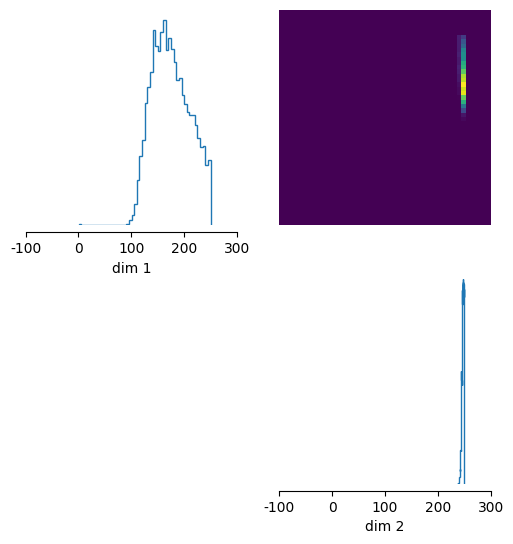

In [29]:
#just NPE
# The prepare for sbi function checks simulator and prior are compatible with the NPE algorithm (and makes sure it adds a batch dimension)
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

# We define the neural network (neural density estimator), specifying the embedding net. In this case we use a mixture density network.
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net_RNN, hidden_features=25, num_transforms=2)

# Setup the inference procedure with the SNPE-C (Greenberg et al, 2019)
inference = SNPE(prior=prior, density_estimator=neural_posterior)
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations, simulation_batch_size=simulation_batch_size, num_workers=num_workers) # Simulate data
density_estimator = inference.append_simulations(theta, x).train()        # Train density estimator
posterior = inference.build_posterior(density_estimator)                  # Build posterior

# Then sample the posterior and plot
posterior_samples = posterior.sample((10000,), x=true_data)
_ = analysis.pairplot(
    posterior_samples, limits=[[-100, 300], [-100, 300]], figsize=(6, 6) #It should be close to 247, but since this is a toy example we are not expecting it to work (just checking it runs).
)